<img align="right" src="https://raw.githubusercontent.com/GT4SD/gt4sd-core/main/docs/_static/gt4sd_logo.png" alt="logo" width="100" height="100"/>

##  Demo: Regression Transformer in the Generative Toolkit for Scientific Discovery


In [1]:
import logging, sys
logging.disable(sys.maxsize)


from gt4sd.algorithms.conditional_generation.regression_transformer import (
    RegressionTransformer, RegressionTransformerMolecules, RegressionTransformerProteins
)
import mols2grid
from rdkit import Chem
from selfies import encoder
import pandas as pd

Using TensorFlow backend.


# Let us have a look at Buturon, a common herbicide

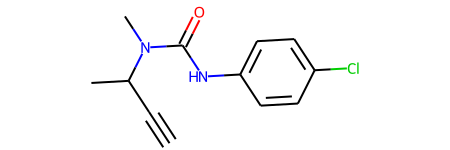

In [2]:
smi = "CC(C#C)N(C)C(=O)NC1=CC=C(Cl)C=C1"
true_esol = -3.9
Chem.MolFromSmiles(smi)

## Buturon has a water solubility score of -3.90
## We can predict its ESOL (estimated solubility) value with the RegressionTransformer

In [3]:
config = RegressionTransformerMolecules(algorithm_version="solubility", search="greedy")
target = f"<esol>[MASK][MASK][MASK][MASK][MASK]|{encoder(smi)}"
esol_predictor = RegressionTransformer(configuration=config, target=target)
score_str = list(esol_predictor.sample(1))[0]
print(f"For Buturuon, the predicted ESOL is {score_str.split('>')[-1]}")

For Buturuon, the predicted ESOL is -5.2467


#### Ok, we can see that the prediction was decently close but not perfect
#### Now let us try to improve Buturuon to a molecule with higher solubility
#### Note, that we will use the same model to do so!


#### We simply set the hyperparameters for the search

In [4]:
target_esol = -3.53
config = RegressionTransformerMolecules(
    algorithm_version="solubility",
    search="sample", # the alternative is 'greedy' but 'sample' is recommended for generative tasks
    temperature=2, 
    tolerance=5, # percentage of tolerated deviation from the desired property value (here -3.53)
    sampling_wrapper={
        'property_goal': {'<esol>': target_esol}, 
        'fraction_to_mask': 0.2
    }
)
esol_generator = RegressionTransformer(
    configuration=config, target=smi
)
generations = list(esol_generator.sample(8))
generations

[('CC(C)=CN(C)C(=O)NC1=CC=C(Cl)C=C1', '<esol>-2.6173'),
 ('CC(C#CN(C)C(=O)NC1)=CC=C(Cl)C=C1', '<esol>-2.5757'),
 ('CC(C#C)N(C)C(=O)NC=CCl', '<esol>-2.5757'),
 ('CCC#CN(C)C(=O)NC1=CC=C(Cl)C=C1', '<esol>-4.0012'),
 ('CCSCC#CN(C)C(=O)NC1=CC=C(Cl)C=C1', '<esol>-4.0012'),
 ('CC(C#C)N(C)C(=O)OC1=CC=C(Cl)C=C1', '<esol>-2.6173'),
 ('CC(C#C)N(C)C(=O)[NH]C1=CC=C(Cl)C=C1', '<esol>-2.6173'),
 ('CC(C#C)(CC)C(=O)NC1=CC=C(Cl)C=C1', '<esol>-4.0012')]

In [5]:
smiles = [g[0] for g in generations]
esols = [float(g[1].split('>')[-1]) for g in generations]
print("\033[1m" "\t\t\tButuruon-inspired molecules with a higher solubility score ")
result = pd.DataFrame({
    "SMILES": [smi] + smiles,
    "Name": ["Buturon"] + len(smiles)*["Novel (from RT)"],
    "ESOL": [true_esol] + [round(e, 3) for e in esols]
})
mols2grid.display(
    result, tooltip=["Name", "SMILES", "ESOL"], size=(300,150),
    fixedBondLength=25, n_cols=3, width="100%", height=None,
    name='Results'
)

			Buturuon-inspired molecules with a higher solubility score 


### If you want, you can constrain the masking to be on specific atom types only
### For example we might want to replace only the Chlorine and Nitrogen atoms

In [6]:
target_esol = -3.53
config = RegressionTransformerMolecules(
    algorithm_version="solubility",
    search="sample", # the alternative is 'greedy' but 'sample' is recommended for generative tasks
    temperature=2, 
    tolerance=5, # percentage of tolerated deviation from the desired property value (here -3.53)
    sampling_wrapper={
        'property_goal': {'<esol>': target_esol}, 
        'fraction_to_mask': 1.0,
        'tokens_to_mask': ['Cl', 'N']
    }
)
esol_generator = RegressionTransformer(
    configuration=config, target=smi
)
generations = list(esol_generator.sample(8))
generations

[('CC(C#C)OCCC(=O)NC1=CC=C([NH])C=C1', '<esol>-1.6485'),
 ('CC(C#C)N(C)C(=O)NC1=CC=C(C)C=C1', '<esol>-2.5757'),
 ('CC(C#C)C(C)C(=O)NC1=CC=C(N)C=C1', '<esol>-3.0878'),
 ('CC(C#C)N(C)C(=O)SC1=CC=C(Cl)C=C1', '<esol>-4.0012'),
 ('CC(C#C)=C(C)C(=O)NC1=CC=C(F)C=C1', '<esol>-2.7141'),
 ('CC(C#C)(CCC)C=O', '<esol>-3.9735'),
 ('CC(C#C)C(C)C(=O)NC1=CC=C(C)C=C1', '<esol>-2.5757'),
 ('CC(C#C)OCCC(=O)OC1=CC=C(F)C=C1', '<esol>-3.0324')]

In [7]:
smiles = [g[0] for g in generations]
esols = [float(g[1].split('>')[-1]) for g in generations]
print("\033[1m" "\t\t\tButuruon-inspired molecules with a higher solubility score ")
result = pd.DataFrame({
    "SMILES": [smi] + smiles,
    "Name": ["Buturon"] + len(smiles)*["Novel (from RT)"],
    "ESOL": [true_esol] + [round(e, 3) for e in esols]
})
mols2grid.display(
    result, tooltip=["Name", "SMILES", "ESOL"], size=(300,150),
    fixedBondLength=25, n_cols=3, width="100%", height=None,
    name='Results'
)

			Buturuon-inspired molecules with a higher solubility score 


### Or directly tweak the SELFIES and mask specific areas

In [8]:
config = RegressionTransformerMolecules(algorithm_version="solubility", search="sample", temperature=2, tolerance=5)
target = "<esol>-3.53|[C][C][Branch1_3][Ring1][C][#C][N][Branch1_3][epsilon][C][C][Branch1_3][epsilon][MASK][MASK][MASK][MASK][C][=C][Branch1_3][epsilon][Cl][C][=C][Ring1][Branch1_2]"

In [9]:
esol_generator = RegressionTransformer(
    configuration=config, target=target
)
generations = list(esol_generator.sample(5))
generations

[('CC(C#C)N(C)C(C)[NH]ON1C=C(Cl)C=C1', '<esol>-4.0012'),
 ('CC(C#C)N(C)C(N)C#CC=C(Cl)C=C', '<esol>-5.2467'),
 ('CC(C#C)N(C)C(=C)OC(C)(Cl)C=C', '<esol>-5.2467'),
 ('CC(C#C)N(C)C(O)CBr', '<esol>-5.2467'),
 ('CC(C#C)N(C)C(=C)N=O', '<esol>-5.2467')]

In [10]:
smiles = [g[0] for g in generations]
esols = [float(g[1].split('>')[-1]) for g in generations]
print("\033[1m" "\t\t\tButuruon-inspired molecules with a higher solubility score ")
result = pd.DataFrame({
    "SMILES": [smi] + smiles,
    "Name": ["Buturon"] + 5*["Novel (from RT)"],
    "ESOL": [true_esol] + [round(e, 3) for e in esols]
})
mols2grid.display(
    result, tooltip=["Name", "SMILES", "ESOL"], size=(300,150),
    fixedBondLength=25, n_cols=3, width="100%", height=None,
    name='Results'
)

			Buturuon-inspired molecules with a higher solubility score 


# Now let's have a look at a multiproperty prediction model!

In [11]:
# List all available RT algorithms
from gt4sd.algorithms.registry import ApplicationsRegistry
algorithms = ApplicationsRegistry.list_available()
for a in algorithms:
    if a['algorithm_name'] == 'RegressionTransformer':
        print(a['algorithm_application'], a['algorithm_version'])

RegressionTransformerMolecules pfas
RegressionTransformerMolecules logp_and_synthesizability
RegressionTransformerMolecules solubility
RegressionTransformerMolecules qed
RegressionTransformerProteins stability


#### Let's go with the `logp_and_synthesizability` model
#### This captures the partition coefficient (logP) and the SCScore 

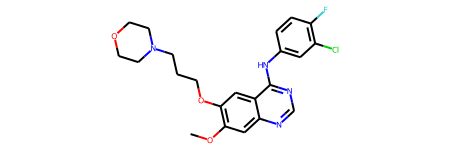

In [12]:
# Let us try to adapt a known cancer drug, Gefinib
gefitinib = 'COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4'
Chem.MolFromSmiles(gefitinib)

In [13]:
# First let's predict the logP and the SCScore

config = RegressionTransformerMolecules(algorithm_version="logp_and_synthesizability", search="greedy")
target = f"<logp>[MASK][MASK][MASK][MASK][MASK]<scs>[MASK][MASK][MASK][MASK][MASK]|{encoder(gefitinib)}"
predictor = RegressionTransformer(configuration=config, target=target)
score_str = list(predictor.sample(1))[0]
print(f"For Gefitinib, the predicted properties are: {score_str}")
true_logp = float(score_str.split('>')[1].split('<')[0])
true_scs = float(score_str.split('>')[-1])

For Gefitinib, the predicted properties are: <logp>7.3782<scs>1.0


In [14]:
config = RegressionTransformerMolecules(
    algorithm_version='logp_and_synthesizability', search='sample', tolerance=35,
    sampling_wrapper={
        'property_goal': {
            '<logp>': 6.123,
            '<scs>': 1.5
        },
        'fraction_to_mask': 0.6,
        'tokens_to_mask': ['C']
    }
)
model = RegressionTransformer(configuration=config, target=gefitinib)

In [15]:
generations = list(model.sample(5))
generations

[('COC1=C(C=C2C(=C1)N=CNC2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4',
  '<logp>8.6396<scs>1.22'),
 ('COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCC#N',
  '<logp>8.6396<scs>2.27'),
 ('COC1=C(N=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)CCCN4CCOCC4',
  '<logp>8.8198<scs>1.2'),
 ('COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)CCCN4CCOCC4',
  '<logp>9.3604<scs>1.6'),
 ('COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)N4CCOCC4',
  '<logp>8.6396<scs>1.6')]

In [16]:
smiles = [g[0] for g in generations]
scscores = [float(g[1].split('>')[-1]) for g in generations]
logps = [float(g[1].split('>')[1].split('<')[0]) for g in generations]

print("\033[1m" "\t\t\tMultiproperty generation")
result = pd.DataFrame({
    "SMILES": [gefitinib] + smiles,
    "Name": ["Gefitinib"] + len(smiles)*["Novel (from RT)"],
    "LogP": [true_logp] + [round(e, 3) for e in logps],
    "SCScore": [true_scs] + [round(e, 3) for e in scscores]
})
mols2grid.display(
    result, tooltip=["Name", "SMILES", "LogP", 'SCScore'], size=(300,150),
    fixedBondLength=25, n_cols=3, width="100%", height=None,
    name='Results'
)

			Multiproperty generation



# 
# 
# 
#  Example on peptide design

In [17]:
target = 'GSQEVNSNASPEEAEIARKAGATTWTEKGNKWEIRI'

# Predict property
config = RegressionTransformerProteins(
    algorithm_version='stability', search='greedy'
)
model = RegressionTransformer(
    configuration=config, target=f"<stab>[MASK][MASK][MASK][MASK][MASK]|{target}"
)
prediction = list(model.sample(1))[0]
print(f"This peptide has a predicted stability of {prediction.split('>')[-1]}")



This peptide has a predicted stability of 0.2


In [18]:
# Decorate the seed
config = RegressionTransformerProteins(
    algorithm_version='stability', search='sample', tolerance=15,
    sampling_wrapper={
        'property_goal': {
            '<stab>': 1.123
        },
        'fraction_to_mask': 0.3
    }
)
model = RegressionTransformer(
    configuration=config, target=target
)


generations = list(model.sample(9))
generations

[('GSQEAESEASPEESEIAYKAGSTAWRRKGAKWEKRI', '<stab>0.09'),
 ('GSQEDRSSASPEEGEIANKAGETNWEWKGRKWEHRI', '<stab>0.035'),
 ('GSQEWTSNASPEETEIANKAGRTDWRKKGWKWEYRI', '<stab>0.09'),
 ('GSQESTSHASPEEAEIAKKAGRTEWQEKGLKWESRI', '<stab>0.145'),
 ('GSQETKSRASPEEEEIARKAGTTWWTKKGPKWENRI', '<stab>0.09'),
 ('GSQEGQSTASPEEAEIAEKAGITRWRYKGYKWEKRI', '<stab>0.2'),
 ('GSQEKKSYASPEEREIARKAGNTIWTRKGDKWEIRI', '<stab>0.2'),
 ('GSQELRSYASPEEREIAEKAGETKWDTKGEKWEQRI', '<stab>0.2'),
 ('GSQEIRSHASPEEEEIAKKAGETTWNTKGDKWESRI', '<stab>0.365')]